# Session 11

## Cloning the repo

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Github/ERA-v1

/content/drive/MyDrive/Github/ERA-v1


In [ ]:
! git config --global user.email "me18b059@smail.iitm.ac.in"
# ! git stash push --include-untracked
# ! git stash drop
! git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), 22.25 KiB | 25.00 KiB/s, done.
From https://github.com/Madhur-1/ERA-v1
   3f5d1a0..ab5de80  master     -> origin/master
Updating 3f5d1a0..ab5de80
^C


In [6]:
%cd S11/

/content/drive/MyDrive/Github/ERA-v1/S11


# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [7]:
!pip install torchmetrics
!pip install torch_lr_finder
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=3a27c3611a1bf799664a069de03c734359463400a2cd22bca8f297cfc607828b
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
# del model
import torch
import torch.nn as nn
import torch.optim as optim
from Utilities.model import ResNet18
from Utilities.utils import train, test
import torch.nn.functional as F
from torchsummary import summary

torch.manual_seed(1)

In [10]:
CLASSES = ("Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck")

# Model Initialization & Summary

In [11]:
device = torch.device("cuda")
model = ResNet18()
summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Dataset & Dataloaders

In [12]:
from Utilities.transforms import train_transforms, test_transforms

In [13]:
from Utilities.dataset import get_dataloaders

batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}
train_loader, test_loader = get_dataloaders(train_transforms=train_transforms, test_transforms=test_transforms, **kwargs)

100%|██████████| 170498071/170498071 [00:02<00:00, 58662966.23it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Exploration

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


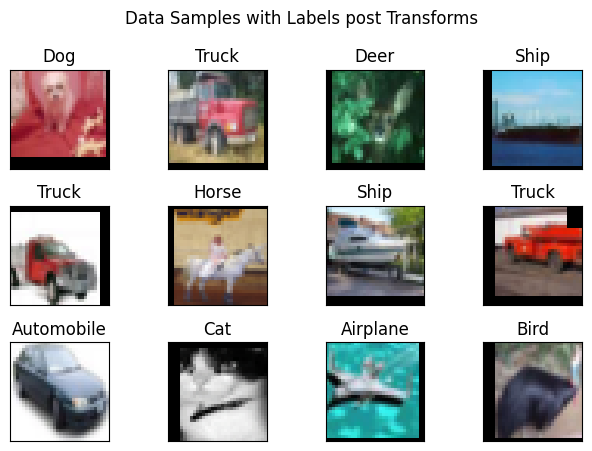

In [14]:
from Utilities.visualize import plot_data_samples, plot_class_label_counts

# plot_class_label_counts(train_loader, classes=CLASSES)
plot_data_samples(train_loader, classes=CLASSES)

# Training

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.91E-03


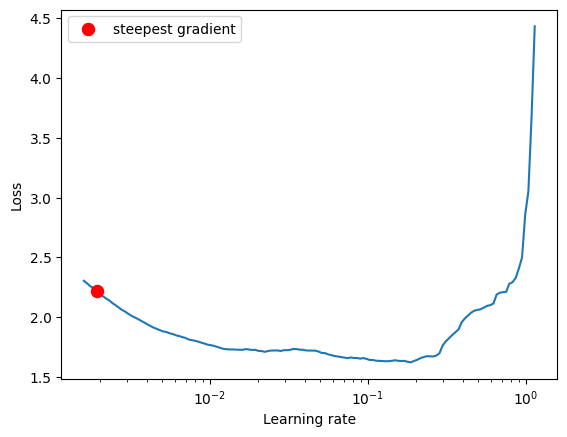

In [15]:
from torch_lr_finder import LRFinder
model = ResNet18(dropout_percentage=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = F.cross_entropy

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [16]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 20

scheduler = OneCycleLR(
        optimizer,
        max_lr=1.91E-03,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(1, EPOCHS+1):
  print(f'Epoch {epoch}')
  train_accs, train_losses = train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_accs)
  test_accs, test_losses = test(model, device, test_loader, criterion, test_losses, test_accs)

Epoch 1
Train: 100% Loss=1.3532 Batch_id=97 Accuracy=39.81
Test set: Average loss: 1.6397, Accuracy: 4259/10000 (42.59%)

Epoch 2
Train: 100% Loss=0.8659 Batch_id=97 Accuracy=59.58
Test set: Average loss: 1.1223, Accuracy: 6241/10000 (62.41%)

Epoch 3
Train: 100% Loss=0.9156 Batch_id=97 Accuracy=69.09
Test set: Average loss: 1.0250, Accuracy: 6755/10000 (67.55%)

Epoch 4
Train: 100% Loss=0.5482 Batch_id=97 Accuracy=75.17
Test set: Average loss: 1.5539, Accuracy: 5866/10000 (58.66%)

Epoch 5
Train: 100% Loss=0.5817 Batch_id=97 Accuracy=78.20
Test set: Average loss: 0.9223, Accuracy: 7010/10000 (70.10%)

Epoch 6
Train: 100% Loss=0.4804 Batch_id=97 Accuracy=81.42
Test set: Average loss: 0.7703, Accuracy: 7447/10000 (74.47%)

Epoch 7
Train: 100% Loss=0.4788 Batch_id=97 Accuracy=84.03
Test set: Average loss: 0.6842, Accuracy: 7647/10000 (76.47%)

Epoch 8
Train: 100% Loss=0.3154 Batch_id=97 Accuracy=86.15
Test set: Average loss: 0.5369, Accuracy: 8234/10000 (82.34%)

Epoch 9
Train: 100% Loss

In [17]:
import pandas as pd
bn_df = pd.DataFrame({'Train Acc': train_accs, 'Test Acc': test_accs, 'Train Loss': train_losses, 'Test Loss': test_losses})
bn_df.to_csv('Store/training_stats.csv', index=False)

In [18]:
import pandas as pd
bn_train = pd.read_csv("Store/training_stats.csv")
bn_train
train_accs = bn_train['Train Acc'].tolist()
test_accs = bn_train['Test Acc'].tolist()
train_losses = bn_train['Train Loss'].tolist()
test_losses = bn_train['Test Loss'].tolist()

In [19]:
torch.save(model.state_dict(), "Store/resnet18trained")

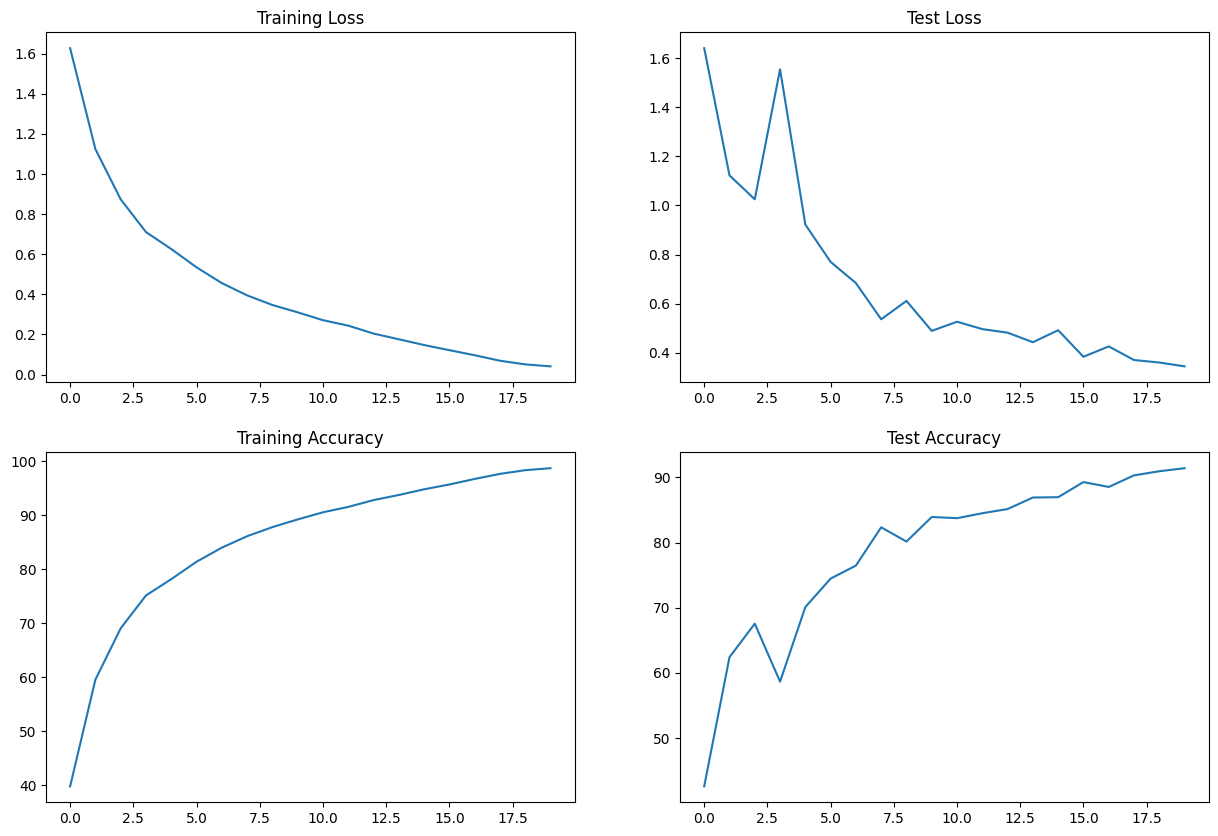

In [20]:
from Utilities.visualize import plot_model_training_curves

plot_model_training_curves(train_accs=train_accs, test_accs=test_accs, train_losses=train_losses, test_losses=test_losses)

# Model Analysis

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


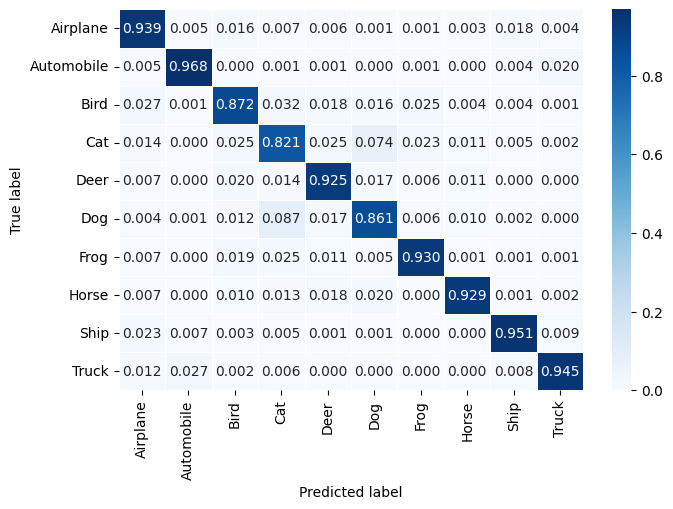

In [22]:
from Utilities.utils import get_all_and_incorrect_preds
from Utilities.visualize import plot_confusion_matrix

model.to(device)
all_preds, all_labels, incorrect = get_all_and_incorrect_preds(model=model, loader=test_loader, device=device)
plot_confusion_matrix(all_labels, all_preds, classes=CLASSES)

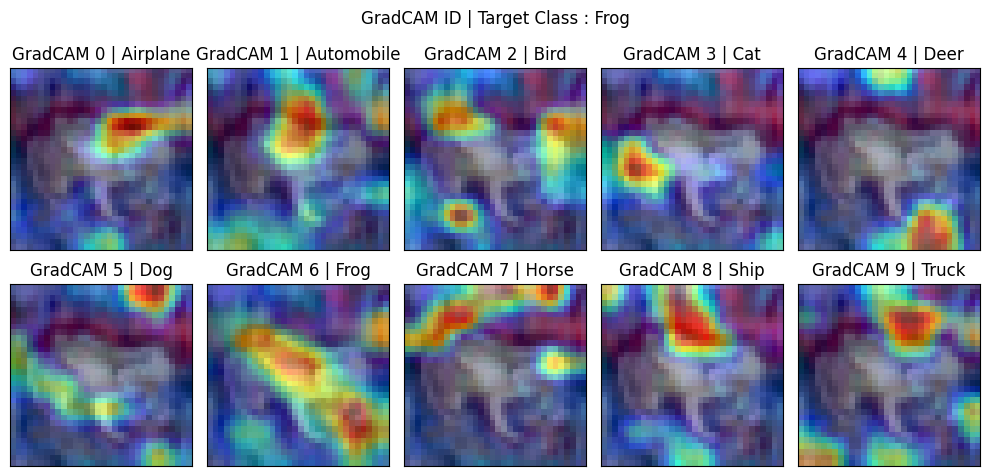

In [29]:
from Utilities.visualize import plot_grad_cam_different_targets

plot_grad_cam_different_targets(model, test_loader, CLASSES, device)

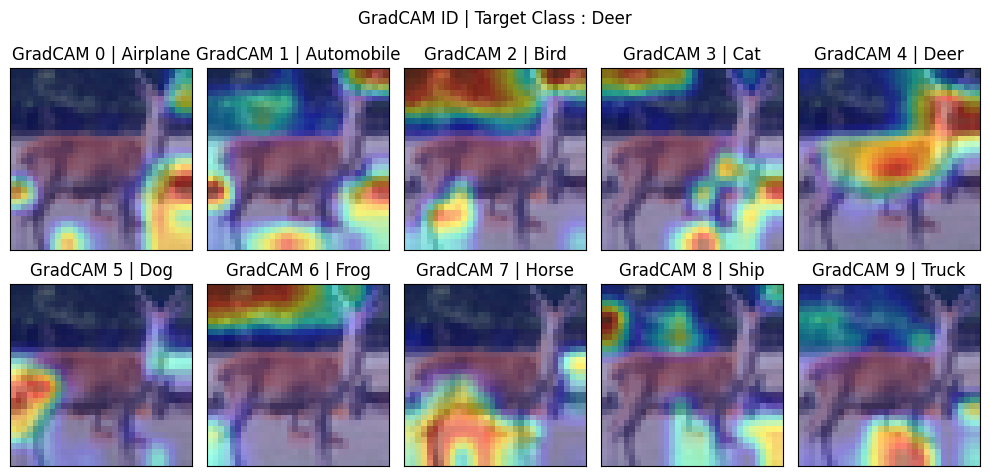

In [28]:
plot_grad_cam_different_targets(model, test_loader, CLASSES, device)

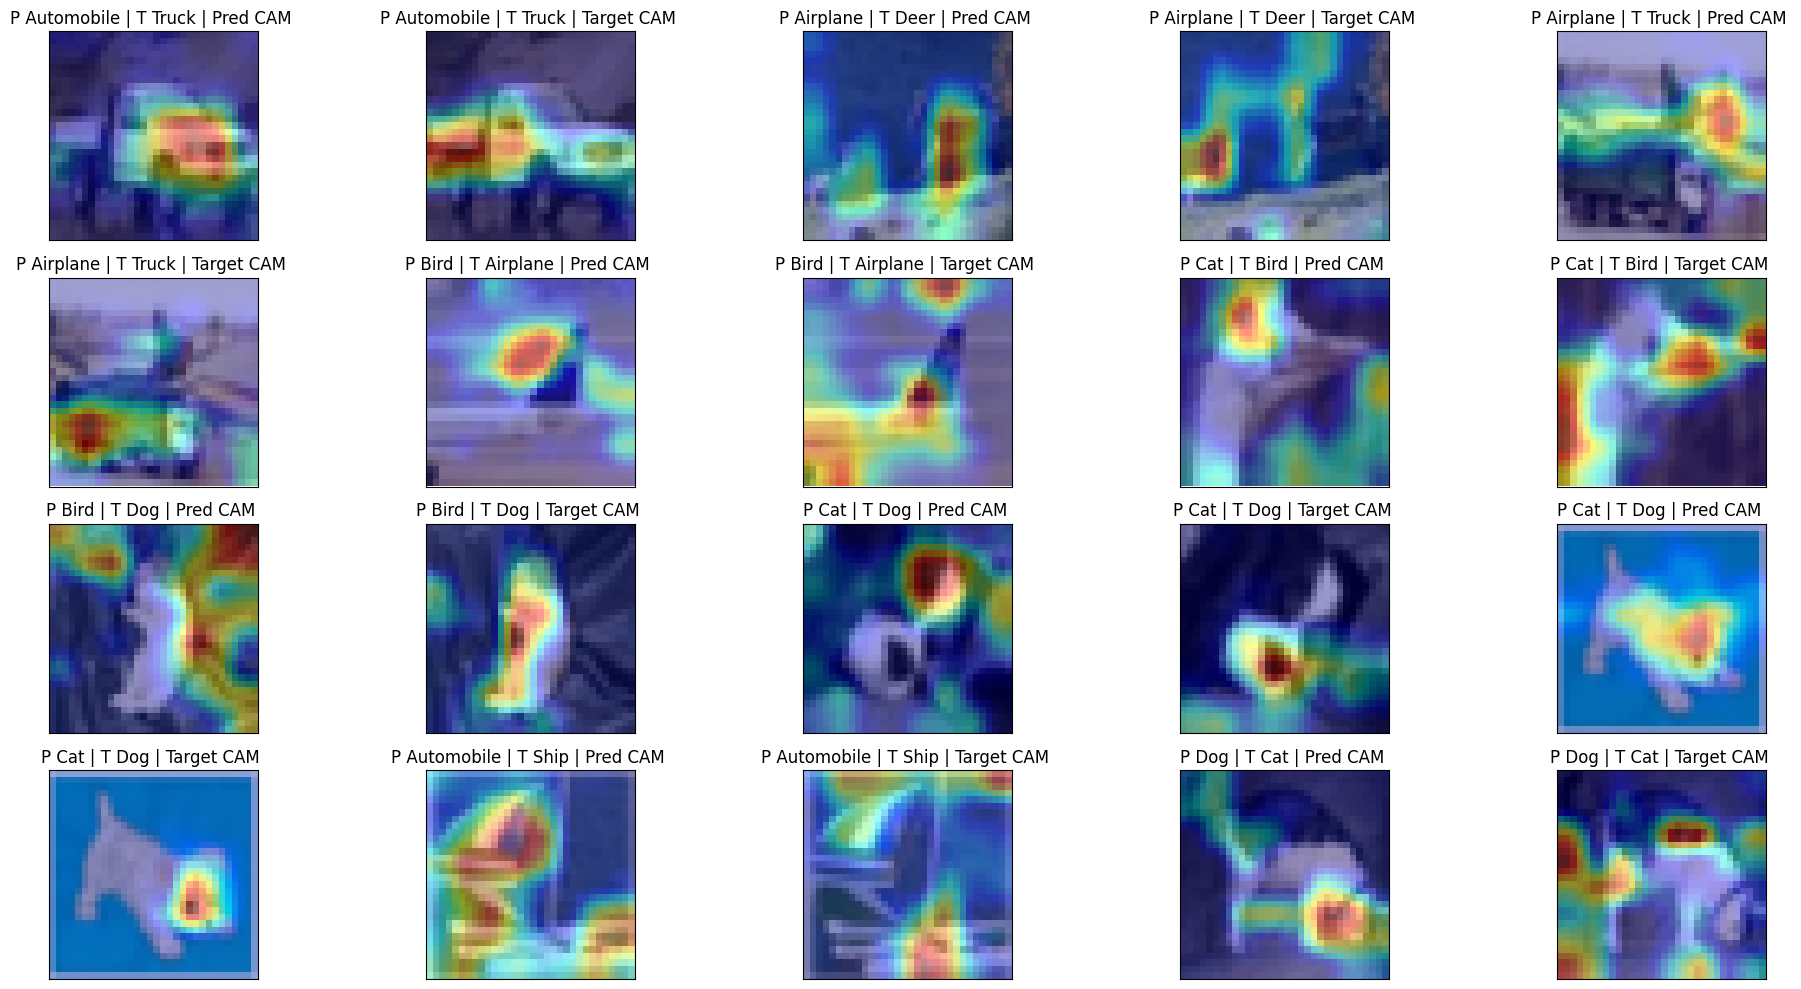

In [24]:
from Utilities.visualize import plot_grad_cam_misclassified

plot_grad_cam_misclassified(model, incorrect, CLASSES, device)

Total Incorrect Predictions 859


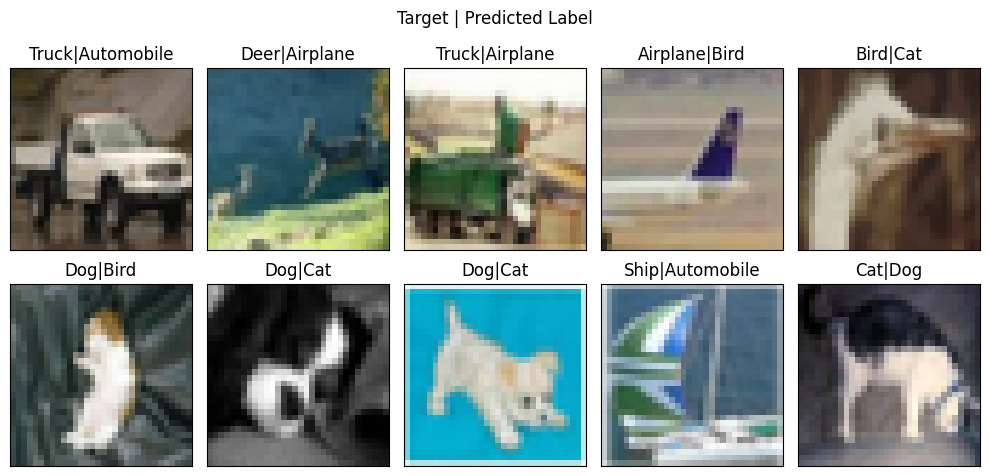

In [30]:
from Utilities.visualize import plot_incorrect_preds

plot_incorrect_preds(incorrect, classes=CLASSES)

### Git Push

In [31]:
!git add .
! git commit -m "S11 commit 91.41%"
! git push

On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
